In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from dlem import util
from dlem import load_model
import seaborn

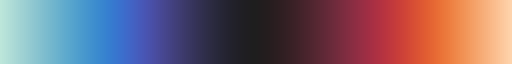

In [2]:
seaborn.color_palette("icefire", as_cmap=True)

In [3]:
dev = torch.device('cuda')

In [4]:
patch = np.log(np.load("data/patch.npy"))

In [5]:
patch = util.tile_patch(patch, kernel_size=10)

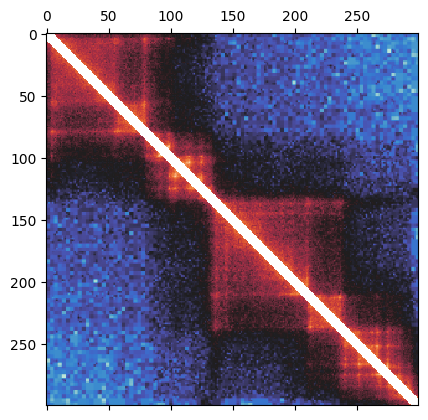

In [6]:
plt.matshow(util.ignore_diag_plot(patch, 5), cmap='icefire')

In [7]:
patch = util.diagonal_normalize(patch[np.newaxis])[0]

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/dlem/util.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.tensor(mat)


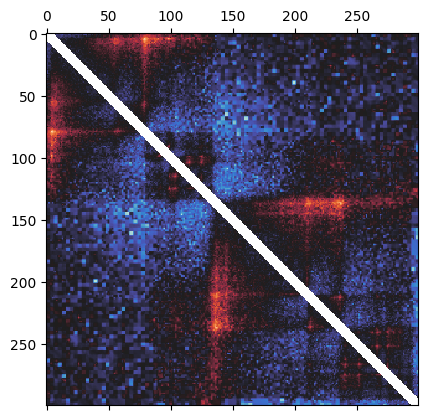

In [8]:
plt.matshow(util.ignore_diag_plot(patch, 5), cmap='icefire')

In [9]:
architecture = load_model("netdlem2")
model = architecture(np.ones(patch.shape[0]) * 0.95, np.ones(patch.shape[0]) * 0.95)#, free_unload=True)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.5)

In [11]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, mode="max")

In [12]:
diag_stop = int(np.floor(patch.shape[0]*0.3)) #we don't get much information from the corner anyway

In [13]:
def weighted_mse_loss(input, target, weight=None):
    if weight is None:
        weight = torch.exp(target)
    return torch.mean(weight * (input - target) ** 2)
loss = torch.nn.MSELoss(reduction='mean')
#loss = weighted_mse_loss

In [14]:
best_loss_model, best_corr_model, arr_loss, arr_corr = util.train(model, optimizer, scheduler, loss, np.exp(patch)[np.newaxis], 3, diag_stop, dev, num_epoch=50)

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/dlem/util.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(dev)
/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/dlem/util.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.tensor(mat)


Text(0, 0.5, 'correlation')

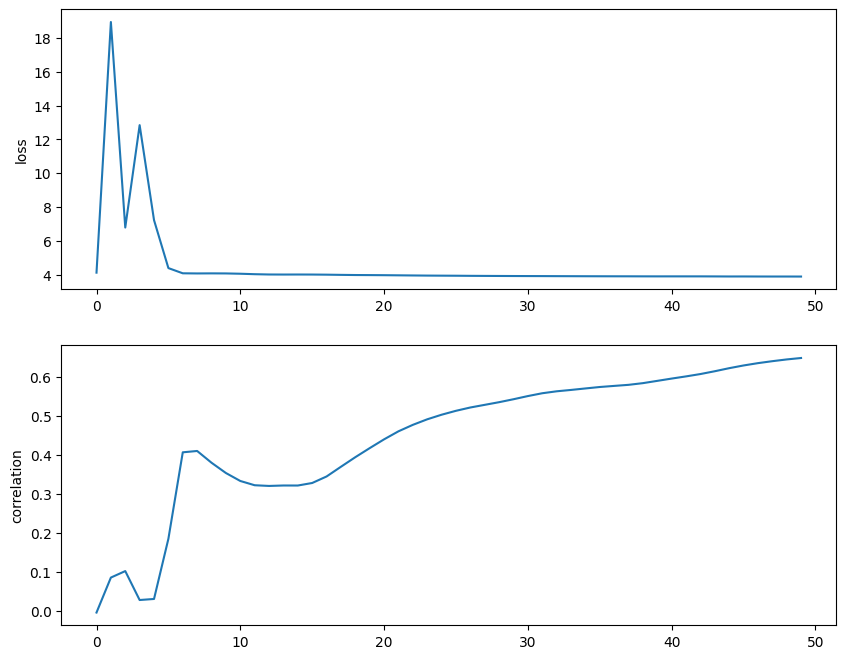

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
axes[0].plot(arr_loss)
axes[0].set_ylabel("loss")
axes[1].plot(arr_corr)
axes[1].set_ylabel("correlation")

In [16]:
best_loss_pred = best_loss_model.contact_map_prediction(torch.ones((1, patch.shape[0]), device=dev) * patch.shape[0]).detach().cpu().numpy()
best_loss_pred = util.diagonal_normalize(np.log(best_loss_pred))
best_loss_pred = best_loss_pred[0]

In [17]:
best_corr_pred = best_corr_model.contact_map_prediction(torch.ones((1, patch.shape[0]), device=dev) * patch.shape[0]).detach().cpu().numpy()
best_corr_pred = util.diagonal_normalize(np.log(best_corr_pred))
best_corr_pred = best_corr_pred[0]

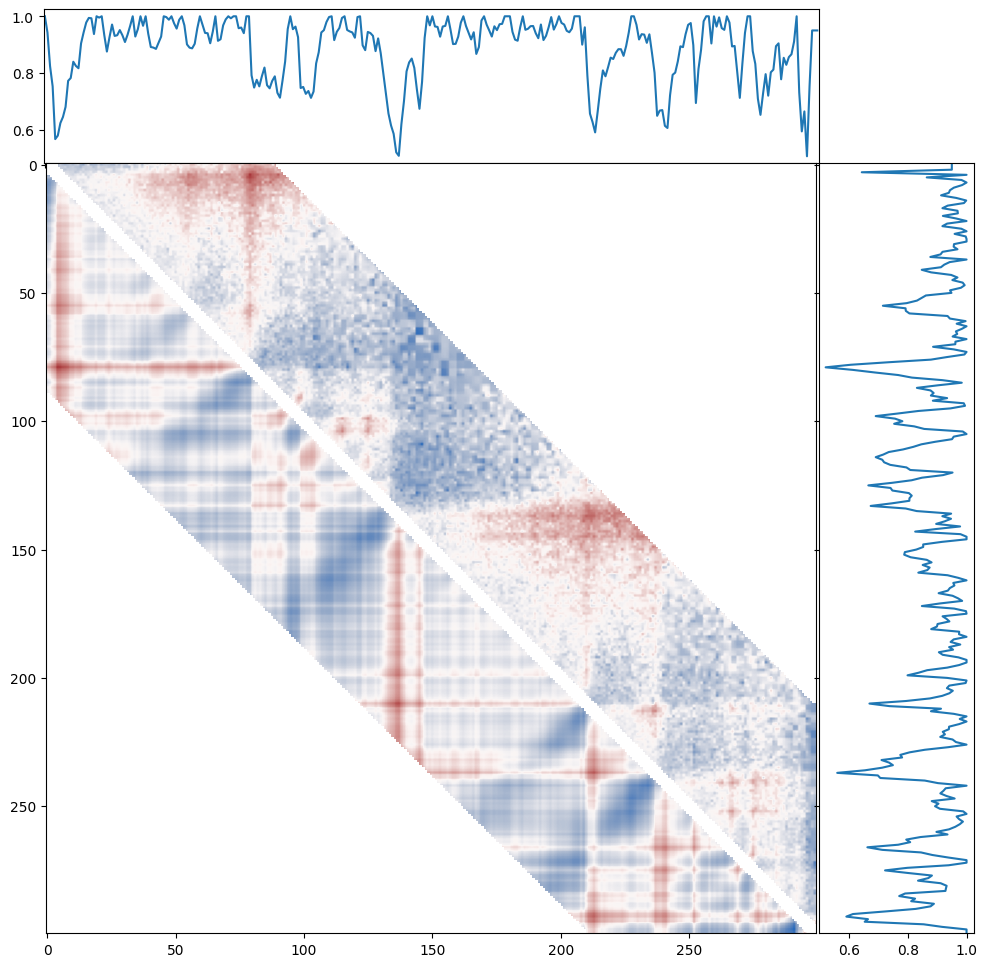

In [18]:
util.plot_results(patch, best_loss_pred, best_loss_model.return_parameters(), cmap="vlag")

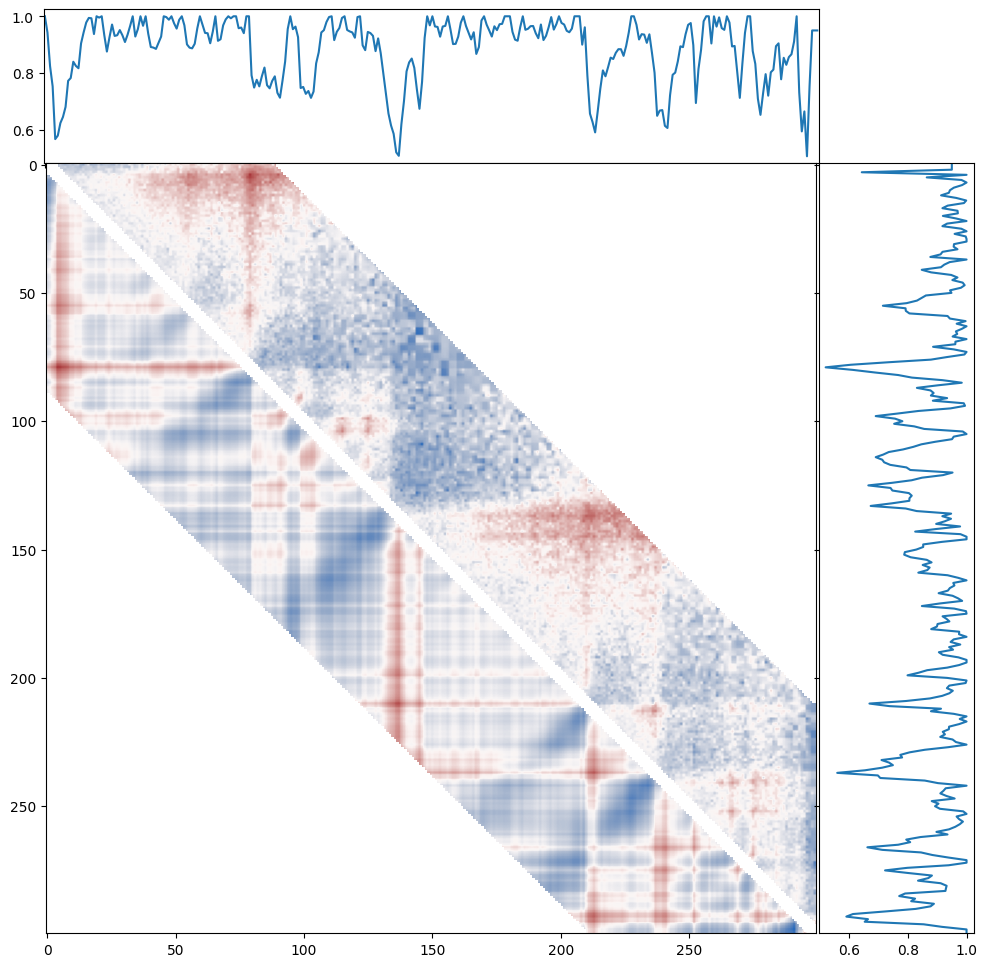

In [19]:
util.plot_results(patch, best_corr_pred, best_corr_model.return_parameters(), cmap="vlag")